# Tarea 3: Los K-vecinos 

## Introducción

<img src="vecinos.png" width="400">

Los $K$-vecinos es un método clásico y muy sencillo para hacer clasificación de datos, que se basa en predecir la etiqueta de un dato basado en las etiquetas de los datos de entrenamiento que más se le parecen. La siguiente figura describe graficamente los tres pasos del algoritmo

<img src="algoritmo.png" width="600">

En este caso es clave definir una noción de distancia entre los ejemplos y también especificar un valor adecuado para $K$, la cantidad de vecinos que influyen en la predicción.

## Formalismo matemático

Sea una base de datos $E = \{(x_j, y_j), j=1, \ldots, N\}$, con $N$ ejemplos donde $x_j \in \mathbb{R}^{D}$ es un atributo d-dimensional e $y_j \in \{0, 1, 2, \ldots, C-1\}$ son sus etiquetas de clase. Sea ahora una segunda base de datos $T = \{(z_i), i=1, \ldots, M\}$ con $M$ ejemplos donde $z_i \in \mathbb{R}^{D}$ es un atributo d-dimensional. Esta base de datos no tiene etiquetas. El objetivo es clasificar los ejemplos de $T$ en base a las etiquetas de los $K$ ejemplos más cercanos de la base de datos $E$


El algoritmo para clasificar el i-esimo elemento de Z es

**Paso 1** Calculamos la distancia entre $z_i$ y cada elemento de $E$ usando

$$
d(z_i, x_j) = \left ( \sum_{d=1}^D  |z_{id} - x_{jd}|^p \right)^{1/p}
$$

que se conoce como [distancia de Minkowski](https://en.wikipedia.org/wiki/Minkowski_distance). Para el caso $p=2$ se recupera la clásica distancia euclidiana.

**Paso 2** Buscamos las $k$ tuplas $(x_k^{(i)}, y_k^{(i)})$ con menor distancia a $z_i$

**Paso 3** Seleccionamos la clase de $z_i$ según

$$
\text{arg}\max_{c=0, 1, \ldots} \sum_{k=1}^K \frac{\mathbb{1}(c=y^{(i)}_k)}{d(z_i, x^{(i)}_k)}
$$

donde 

$$
\mathbb{1}(a=b) = \begin{cases} 1 & \text{si } a=b \\ 0 &  \text{si } a\neq b \end{cases}
$$

se conoce como función indicadora. Esta versión particular del algoritmo se conoce como clasificador de $k$ vecinos ponderado, ya que una menor distancia (mayor cercanía) aumenta el peso del voto

## Instrucciones generales 

1. Forme un grupo de **máximo tres estudiantes**
1. Versione su trabajo usando un **repositorio privado de github**. Agregue a sus compañeros y a su profesor (usuario github: phuijse) en la pestaña *Settings/Manage access*. No se aceptarán consultas de programación si no se cumple este requisito
1. Su tarea se evaluará en base al último commit antes de la fecha de entrega: **23:59 del Martes 20 de Julio de 2021**. La nota se calcula como ("pt totales" + 1)
1. [Sean leales y honestos](https://www.acm.org/about-acm/code-of-ethics-in-spanish), no copie ni comparta resultados con otros grupos

## Instrucciones de la actividad

- (1pt) Considere la implementación "ingenua" del algoritmo KNN que se adjunta a esta tarea con los parámetros $p$ y $k$ por defecto
    - Use la función adjunta `create_data` para crear un conjunto de `N=1000` datos
    - Realice un profiling completo de la función `KNN` usando las magias `timeit`, `prun` y `lprun`
    - Reporte sus resultados y comente sobre los cuellos de botella del algoritmo
- (2pt) Implemente una nueva versión de la función `KNN`
    - Utilice `Cython` con tipos fijos, vistas de arreglos y funciones de la librería estándar matemática de `C`
    - Muestre que obtiene el mismo resultado que la versión original
    - Grafique el *speed-up* de su nueva función con respecto a la implementación "inocente" original para $N=[10, 50, 100, 500, 1000, 5000, 10000]$
- (2pt) Usando la nueva versión de `KNN` y el conjunto de `N=1000` datos creados con `create_data` realice una validación cruzada en el conjunto $E$ para encontrar el mejor valor de los parámetros $k$ y $p$
- (1pt) Evalue su mejor clasificador en el conjunto $T$ y haga un reporte completo de resultados que incluya curvas ROC y las métricas vistas en el curso. Muestre una gráfica de la frontera de decisión de su clasificador en el rango $[(-2,2), (-2,2)]$

**Justifique adecuadamente todas sus decisiones de diseño**

A continuación se muestra una gráfica con los datos a utilizar en esta tarea

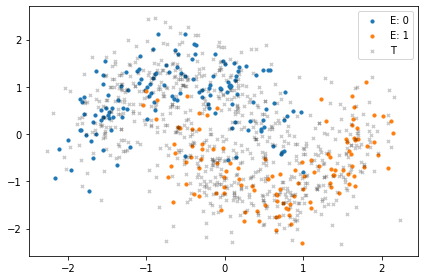

In [126]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from funciones import create_data, KNN

E, T = create_data(N=1000)
x, y = E # Use E para realizar validación cruzada
z, w = T # Use las etiquetas w para evaluar sus resultados finales

fig, ax = plt.subplots(figsize=(6, 4), tight_layout=True)
for c in np.unique(y):
    mask = y == c
    ax.scatter(x[mask, 0], x[mask, 1], label=f"E: {c}", s=10)
ax.scatter(z[:, 0], z[:, 1], c='k', s=10, marker='x',  alpha=0.2, label='T')
ax.legend();

# Desarrollo

In [2]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from funciones import create_data, KNN

## Considere la implementación "ingenua" del algoritmo KNN que se adjunta a esta tarea con los parámetros $p$ y $k$ por defecto

    - Use la función adjunta `create_data` para crear un conjunto de `N=1000` datos
    - Realice un profiling completo de la función `KNN` usando las magias `timeit`, `prun` y `lprun`
    - Reporte sus resultados y comente sobre los cuellos de botella del algoritmo


In [17]:
E, T = create_data(N=1000)
x,y = E
z = T[0]

In [18]:
timeit = %timeit -r20 -q -o KNN(x,y,z)
prun = %prun -r -s cumtime KNN(x,y,z)
%load_ext line_profiler
lprun = %lprun -r -f KNN KNN(x,y,z)

 The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [19]:
print("Usando la magia timeit, tenemos: ",timeit)
print("Desviación estandar de timeit:    %s" %timeit.stdev)
print("Promedio de timeit:               %s" %timeit.average)
print("El mejor resultado de timeit:     %s" %timeit.best)
print("El peor resultado de timeit:      %s\n" %timeit.worst)

print("\nUsando la magia prun, tenemos: ")
print(prun.print_stats())

print("\nUsando la magia lprun, tenemos:")
print(lprun.print_stats())

Usando la magia timeit, tenemos:  1.87 s ± 39.9 ms per loop (mean ± std. dev. of 20 runs, 1 loop each)
Desviación estandar de timeit:    0.03991534698083074
Promedio de timeit:               1.865048270000034
El mejor resultado de timeit:     1.822973985000317
El peor resultado de timeit:      1.9687634670008265


Usando la magia prun, tenemos: 
         1707777 function calls in 2.298 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    2.298    2.298 {built-in method builtins.exec}
        1    0.000    0.000    2.298    2.298 <string>:1(<module>)
        1    1.193    1.193    2.298    2.298 funciones.py:14(KNN)
   189000    0.106    0.000    1.094    0.000 <__array_function__ internals>:2(sum)
   189752    0.087    0.000    0.969    0.000 {built-in method numpy.core._multiarray_umath.implement_array_function}
   189000    0.175    0.000    0.873    0.000 fromnumeric.py:2111(sum)
   189000    

__R: AQUÍ COMENTO__

## (2pt) Implemente una nueva versión de la función `KNN`

    - Utilice `Cython` con tipos fijos, vistas de arreglos y funciones de la librería estándar matemática de `C`
    - Muestre que obtiene el mismo resultado que la versión original
    - Grafique el *speed-up* de su nueva función con respecto a la implementación "inocente" original para $N=[10, 50, 100, 500, 1000, 5000, 10000]$

In [25]:
%load_ext cython 

The cython extension is already loaded. To reload it, use:
  %reload_ext cython


In [122]:
%%cython -a -l m
import cython
cimport numpy as npc
import numpy as np

cdef extern from "math.h":
    float pow(float,float)
    float fabs(float)

@cython.boundscheck(False)
@cython.wraparound(False)
@cython.cdivision(True)

def KNN_c(npc.float64_t [:, ::1] X, int [::1] Y, npc.float64_t [:, ::1] Z, int k = 5, npc.float64_t p=2.):
    C = np.unique(Y)
    cdef int [::1] C_view = C
    cdef int C_c = len(C_view)
    cdef int N = X.shape[0]
    cdef int D = X.shape[1]
    cdef int M = Z.shape[0]
    dist = np.zeros(shape=(M, N), dtype=float)
    cdef npc.float64_t [:, ::1] dist_view = dist
    cdef Py_ssize_t i, j, c
    for i in range(M):
        for j in range(N):
            for l in range(D):
                dist_view[i, j] += pow(fabs(Z[i, l] - X[j, l]), p)
            dist_view[i, j] =  pow(dist_view[i, j], 1./p)
    neighbours = np.ascontiguousarray(np.argsort(dist, axis=1)[:,:k],dtype=np.int32)
    cdef int [:, ::1] neighbours_view = neighbours
    Z_Y = np.zeros(shape=(M, ),dtype=np.float64)
    cdef npc.float64_t [::1] Z_Y_view = Z_Y
    criterion = np.zeros(shape=(C_c,))
    cdef npc.float64_t [::1] criterion_view = criterion
    cdef npc.float64_t maximo = 0.0
    cdef int arg_maximo = 0
    for i in range(M):
        for j in range(C_c):
            criterion_view[j] = 0.0
        for c in range(C_c):
            for l in range(k):
                if Y[neighbours_view[i,l]] == c:
                    criterion_view[c] += 1./dist_view[i, neighbours_view[i,l]] 
            if criterion_view[c]> maximo:
                arg_maximo = c
                maximo = criterion_view[c]
        Z_Y_view[i] = arg_maximo
        arg_maximo = 0
        maximo = 0.0
    return Z_Y


In [115]:
E, T = create_data(N=1000)
x,y = E
z,_ = T
x_d = x.astype(np.float64)
y_d = y.astype(np.int32)
z_d = z.astype(np.float64)
# verificamos si los resultados son iguales
display(np.allclose(KNN(x,y,z),KNN_c(x_d,y_d,z_d)))

#se calcula los tiempos para KNN inocente y la que implementa cython.
%timeit -r3 -n1 KNN(x,y,z)
%timeit -r10 -n1 KNN_c(x_d,y_d,z_d)

True

1.92 s ± 32.4 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
19.8 ms ± 767 µs per loop (mean ± std. dev. of 10 runs, 1 loop each)


__R: Aquí va la explicación de los resultados__

In [102]:
def i_time(n):  
    E, T = create_data(n)
    x,y = E
    z,_ = T
    x_d = x.astype(np.float64)
    y_d = y.astype(np.int32)
    z_d = z.astype(np.float64)
    r1 = %timeit -r1 -n1 -o KNN(x,y,z)
    r2 = %timeit -r1 -n1 -o KNN_c(x_d,y_d,z_d)
    return r1.average,r2.average

def make_speed_up(time):
    s_p = np.zeros(shape=(time.shape[0]), dtype=np.double)
    for i in range(time.shape[0]):
        s_p[i] = time[i,0]/time[i,1]
    return s_p

In [103]:
N = np.array([10,50,100,500,1000,5000,10000])
time = np.zeros(shape=(N.shape[0],2), dtype=np.double)
for i,n in enumerate(N):
    time[i] = i_time(n)
speed_up = make_speed_up(time)

776 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
161 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
14.4 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
233 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
20.6 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
210 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
495 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
4.5 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
1.93 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
26.9 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
48.1 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
517 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
3min 13s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
2.29 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


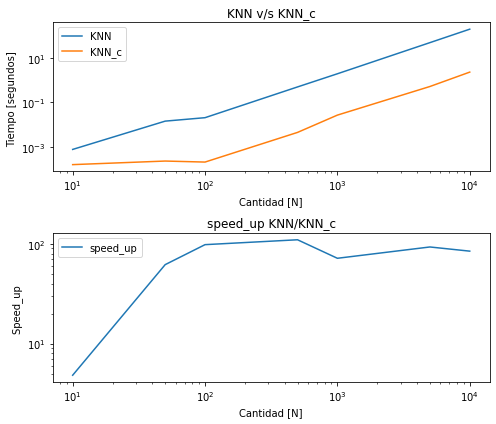

In [106]:
fig ,ax = plt.subplots(nrows = 2,ncols = 1, figsize = (7,6),tight_layout=True)


ax[0].plot(N,time[:,0],label='KNN')
ax[0].plot(N,time[:,1],label='KNN_c')
ax[0].set_xscale('log')
ax[0].set_yscale('log')

ax[0].set_xlabel('Cantidad [N]')
ax[0].set_ylabel('Tiempo [segundos] ')
ax[0].set_title('KNN v/s KNN_c')

ax[0].legend()

ax[1].plot(N,speed_up,label='speed_up')
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].set_xlabel('Cantidad [N]')
ax[1].set_ylabel('Speed_up ')
ax[1].set_title('speed_up KNN/KNN_c')
ax[1].legend()

__R: COMENTAR EL GRÁFICO__

## (2pt) Usando la nueva versión de `KNN` y el conjunto de `N=1000` datos creados con `create_data` realice una validación cruzada en el conjunto $E$ para encontrar el mejor valor de los parámetros $k$ y $p$

In [153]:
from sklearn.model_selection import KFold
def correctitud(v,d):
    E, T = create_data(1000)
    x,y = E
    z,w = T
    x = x.astype(np.float64)
    y = y.astype(np.int32)
    z = z.astype(np.float64)

    kf = KFold(n_splits=10) # 10 particiones

    total = np.zeros(shape=(v,d))
    for k_vecinos in range(1, v):# para cada k-vecino
        for p_distancia in range(1,d):# para cada p-distancia 
            score = np.zeros(shape=(kf.get_n_splits(), ))
            for i, (train_index, valid_index) in enumerate(kf.split(x)):
                w_pred = KNN_c(x[train_index],y[train_index],z,k_vecinos,p_distancia)
                c = 0
                for j,k in enumerate(w_pred):
                    if w[j] == k:
                        c+=1     
                score[i] = c/w.shape[0]
            total[k_vecinos,p_distancia] = np.amax(score)
    return total
        

In [154]:
total = correctitud(20,10)
print("correctitud = ",total.max(),", error = ",(1-total.max()))
k,p = [x[0] for x in np.where(total == total.max())]
print("k = ",k,", p = ",p)

correctitud =  0.9573333333333334 , error =  0.04266666666666663
k =  13 , p =  5


In [169]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from funciones import create_data, KNN

E, T = create_data(N=1000)
x, y = E 
z, w = T 

x = x.astype(np.float64)
y = y.astype(np.int32)
z = z.astype(np.float64)

fig, ax = plt.subplots(figsize=(6, 4), tight_layout=True)
for c in np.unique(y):
    mask = KNN_c(x,y,z,k,p) == c
    ax.scatter(z[mask, 0], z[mask, 1], label=f"E: {c}", s=10)
ax.scatter(z[:, 0], z[:, 1], c='k', s=10, marker='x',  alpha=0.2)
ax.legend();

<IPython.core.display.Javascript object>